In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [19]:
from util_results import Results

In [20]:
from te_datasim.lineargaussian import MVLinearGaussianSimulator

In [21]:
import torch; torch.set_printoptions(sci_mode=None)
# Check if CUDA is available
if torch.cuda.is_available():
    compute_device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    compute_device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [22]:
from reference_njee import NJEE_train_models
BATCH_SIZE = 1000
N_BINS = 25

In [23]:
# Initialize data generator
lg_generator = MVLinearGaussianSimulator(n_dim=1, coupling=0.5)
X_data, Y_data = lg_generator.simulate(time=200, seed=0)

### Train Model for $p(y_{t+1}|y_t)$ for 20000 epochs

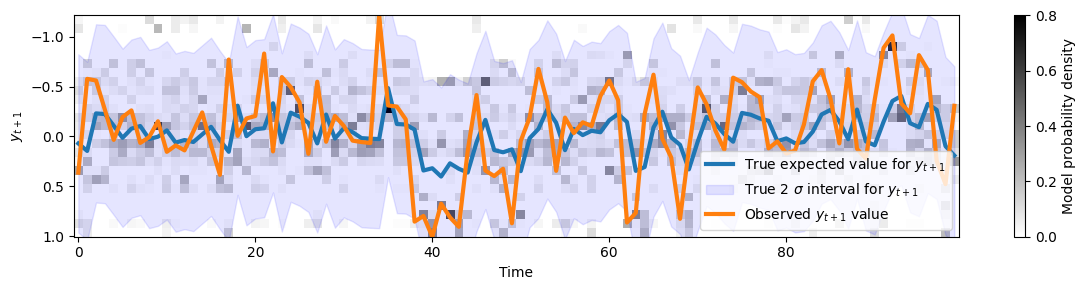

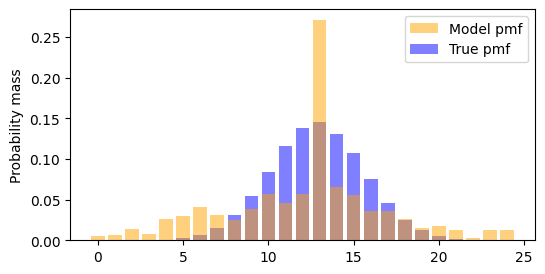

In [24]:
var_from = X_data
var_to = Y_data

X_past = var_from[:-1]
Y_past = var_to[:-1]
Y_future = var_to[1:]

models = NJEE_train_models(
        X=Y_future, 
        Y=[Y_past],
        device=compute_device, 
        n_bins=25,
        hidden_size=100,
        epochs=20001,
        batch_size=1000,)

X_data_test, Y_data_test = lg_generator.simulate(time=101, seed=0)
var_from = X_data_test
var_to = Y_data_test

X_past_test = var_from[:-1]
Y_past_test = var_to[:-1]
Y_future_test = var_to[1:]

X=Y_future_test 
Y=[Y_past_test]
# Prepare input data
input_lst = [[] for _ in range(1)]
for n in range(1):
# input is the 1, 2, ..., n-1-th dimension of X, and all of Y
    base_input = np.concatenate(Y, axis=1)
    if   n == 0:
        # corresponds to the input "Y" for H(X_1|Y)
        input_full = base_input
    elif n >= 1:
        # corresponds to the input "X_1, ..., X_{n-1}, Y" for H(X_n|X_1, ..., X_{n-1}, Y)
        input_full = np.concatenate([X[:, :n], base_input], axis=1)
    
    for i in range(0, X.shape[0], BATCH_SIZE):
        input = input_full[i:i + BATCH_SIZE]

        input = torch.tensor(input, dtype=torch.float32).contiguous().to(compute_device)
        input_lst[n].append(input)

# Compute the output
output = models[0](input_lst[0][0])
output = np.round(output.cpu().detach().numpy(),2)

# Plot the results
plt.figure(figsize=(12, 3))
true_value = []
for i in range(0, 100):
    true_value.append(0.4*Y_past_test[i])
true_value_plot = np.array(true_value)
plt.plot(true_value_plot, label='True expected value for $y_{t+1}$', linewidth=3,)

conf_interval = np.sqrt(0.2)*2
bottom = np.array(true_value_plot - conf_interval).reshape(-1)
top = np.array(true_value_plot + conf_interval).reshape(-1)
plt.fill_between(np.arange(0, 100), bottom, top, color='blue', alpha=0.1, label='True 2 $\sigma$ interval for $y_{t+1}$')

Y_future_plot = Y_future_test
plt.plot(Y_future_plot, label='Observed $y_{t+1}$ value', linewidth=3)

plt.imshow(output.T, cmap='binary', interpolation='none', aspect='auto',zorder=0, extent=[-0.5, 99.5, Y_future_test.max(), Y_future_test.min()])
plt.colorbar(label='Model probability density')

plt.xlabel('Time')
plt.ylabel('$y_{t+1}$')
plt.legend()
plt.tight_layout()
plt.savefig('NJEE_overfit_train.pdf')

plt.figure(figsize=(6, 3))
residual_hist = np.zeros_like(output)
for i in range(100):
    maxprob_idx = np.argmax(output[i])
    for j in range(25):
        if 0 <= j+maxprob_idx-13 < 25:
            residual_hist[i, j] = output[i, j+maxprob_idx-13]

plt.bar(list(range(25)), np.mean(residual_hist,axis=0), color = 'orange', label='Model pmf', zorder=1, alpha=0.5)

normal_samples = np.random.normal(0, np.sqrt(0.2), 100000)
histogram = np.histogram(normal_samples,  bins=25)[0]/100000
plt.bar(list(range(25)), histogram, color='blue', zorder=0, label='True pmf', alpha=0.5)
plt.legend()
plt.ylabel('Probability mass')
plt.savefig('NJEE_overfit_train_hist.pdf')

### Train Model for $p(y_{t+1}|x_t, y_t)$ for 20000 epochs

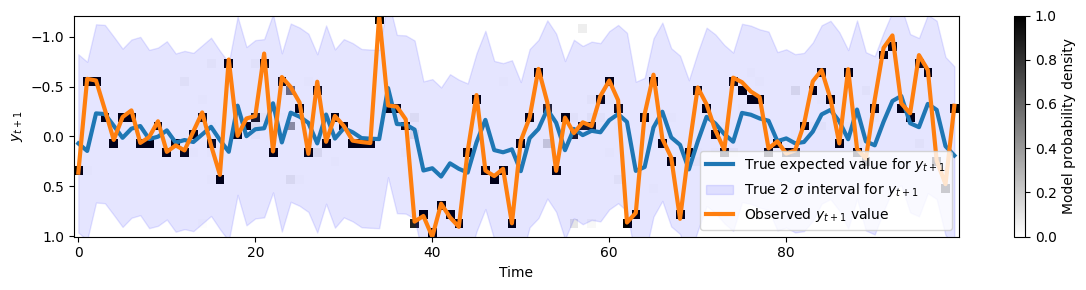

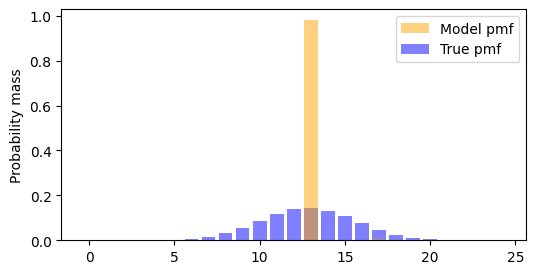

In [25]:
var_from = X_data
var_to = Y_data

X_past = var_from[:-1]
Y_past = var_to[:-1]
Y_future = var_to[1:]

models = NJEE_train_models(
        X=Y_future, 
        Y=[X_past, Y_past],
        device=compute_device, 
        n_bins=25,
        hidden_size=100,
        epochs=20001,
        batch_size=1000,)

X_data_test, Y_data_test = lg_generator.simulate(time=101, seed=0)
var_from = X_data_test
var_to = Y_data_test

X_past_test = var_from[:-1]
Y_past_test = var_to[:-1]
Y_future_test = var_to[1:]

X=Y_future_test 
Y=[X_past_test, Y_past_test]
# Prepare input data
input_lst = [[] for _ in range(1)]
for n in range(1):
# input is the 1, 2, ..., n-1-th dimension of X, and all of Y
    base_input = np.concatenate(Y, axis=1)
    if   n == 0:
        # corresponds to the input "Y" for H(X_1|Y)
        input_full = base_input
    elif n >= 1:
        # corresponds to the input "X_1, ..., X_{n-1}, Y" for H(X_n|X_1, ..., X_{n-1}, Y)
        input_full = np.concatenate([X[:, :n], base_input], axis=1)
    
    for i in range(0, X.shape[0], BATCH_SIZE):
        input = input_full[i:i + BATCH_SIZE]

        input = torch.tensor(input, dtype=torch.float32).contiguous().to(compute_device)
        input_lst[n].append(input)

# Compute the output
output = models[0](input_lst[0][0])
output = np.round(output.cpu().detach().numpy(),2)

# Plot the results
plt.figure(figsize=(12, 3))
true_value = []
for i in range(0, 100):
    true_value.append(0.4*Y_past_test[i])
true_value_plot = np.array(true_value)
plt.plot(true_value_plot, label='True expected value for $y_{t+1}$', linewidth=3,)

conf_interval = np.sqrt(0.2)*2
bottom = np.array(true_value_plot - conf_interval).reshape(-1)
top = np.array(true_value_plot + conf_interval).reshape(-1)
plt.fill_between(np.arange(0, 100), bottom, top, color='blue', alpha=0.1, label='True 2 $\sigma$ interval for $y_{t+1}$')

Y_future_plot = Y_future_test
plt.plot(Y_future_plot, label='Observed $y_{t+1}$ value', linewidth=3)

plt.imshow(output.T, cmap='binary', interpolation='none', aspect='auto',zorder=0, extent=[-0.5, 99.5, Y_future_test.max(), Y_future_test.min()])
plt.colorbar(label='Model probability density')

plt.xlabel('Time')
plt.ylabel('$y_{t+1}$')
plt.legend()
plt.tight_layout()
plt.savefig('NJEE_overfit_train2.pdf')

plt.figure(figsize=(6, 3))
residual_hist = np.zeros_like(output)
for i in range(100):
    maxprob_idx = np.argmax(output[i])
    for j in range(25):
        if 0 <= j+maxprob_idx-13 < 25:
            residual_hist[i, j] = output[i, j+maxprob_idx-13]

plt.bar(list(range(25)), np.mean(residual_hist,axis=0), color = 'orange', label='Model pmf', zorder=1, alpha=0.5)

normal_samples = np.random.normal(0, np.sqrt(0.2), 100000)
histogram = np.histogram(normal_samples,  bins=25)[0]/100000
plt.bar(list(range(25)), histogram, color='blue', zorder=0, label='True pmf', alpha=0.5)
plt.legend()
plt.ylabel('Probability mass')
plt.savefig('NJEE_overfit_train_hist2.pdf')